### [Step 0] 기본 설정 & 공통 헬퍼

In [19]:
import re

# 원본 클러스터링 결과를 raw_text 변수에 담아두었다고 가정
raw_text = \
"""
>Cluster 0
0	1245aa, >7O9W|A... *
>Cluster 1
0	180aa, >7NP1|A... at 100.00%
1	1134aa, >7R40|A... *
2	686aa, >7S0E|A... at 99.71%
3	200aa, >7SOC|A... at 98.50%
4	194aa, >7SWN|A... at 100.00%
5	186aa, >7VYR|A... at 100.00%
6	1134aa, >7WO5|A... at 99.29%
7	199aa, >7WRV|A... at 92.46%
8	183aa, >7X7O|A... at 100.00%
9	1120aa, >7YQX|A... at 96.88%
10	1120aa, >7YQZ|A... at 96.88%
11	195aa, >7ZF9|A... at 91.28%
12	1132aa, >7ZR7|A... at 98.50%
>Cluster 2
0	812aa, >7TEE|A... *
>Cluster 3
0	468aa, >6X97|A... at 99.79%
1	469aa, >7TFO|A... *
>Cluster 4
0	449aa, >7EW5|A... *
>Cluster 5
0	309aa, >7NX3|A... *
>Cluster 6
0	287aa, >7UED|A... *
>Cluster 7
0	250aa, >7T25|A... *
>Cluster 8
0	208aa, >7SHY|A... *
>Cluster 9
0	207aa, >7SJN|A... *
1	207aa, >7SJO|A... at 99.52%
>Cluster 10
0	151aa, >7Z4T|A... *
>Cluster 11
0	143aa, >7SGM|A... *
>Cluster 12
0	134aa, >7SBG|A... *
>Cluster 13
0	132aa, >7VNG|A... *
>Cluster 14
0	117aa, >7SU0|A... *
1	115aa, >7SU1|A... at 100.00%
>Cluster 15
0	107aa, >7Z2M|A... *
>Cluster 16
0	95aa, >7KF0|A... *
1	95aa, >7KF1|A... at 100.00%
"""

clusters = {}
current_cluster = None
for line in raw_text.splitlines():
    line = line.strip()
    if not line:
        continue
    # 클러스터 헤더
    if line.startswith('>Cluster'):
        current_cluster = int(line.split()[1])
        clusters[current_cluster] = []
    else:
        # “>7O9W|A...” 형태에서 7O9W만 꺼내 소문자로 변환
        m = re.search(r'>\s*([0-9A-Za-z]+)\|', line)
        if m:
            antigen_pdb_id = m.group(1).lower()
            clusters[current_cluster].append(antigen_pdb_id)

print(clusters)

{0: ['7o9w'], 1: ['7np1', '7r40', '7s0e', '7soc', '7swn', '7vyr', '7wo5', '7wrv', '7x7o', '7yqx', '7yqz', '7zf9', '7zr7'], 2: ['7tee'], 3: ['6x97', '7tfo'], 4: ['7ew5'], 5: ['7nx3'], 6: ['7ued'], 7: ['7t25'], 8: ['7shy'], 9: ['7sjn', '7sjo'], 10: ['7z4t'], 11: ['7sgm'], 12: ['7sbg'], 13: ['7vng'], 14: ['7su0', '7su1'], 15: ['7z2m'], 16: ['7kf0', '7kf1']}


In [20]:
import json

# JSON으로 저장
with open("antigen_clusters.json", "w") as fp:
    json.dump(clusters, fp, indent=2)

print("antigen_clusters.json 파일이 생성되었습니다.")

antigen_clusters.json 파일이 생성되었습니다.


In [21]:
all_ids = sorted({pid for ags in clusters.values() for pid in ags})

ab_native = {pid: pid for pid in all_ids}

# ④ JSON 저장
with open("ab_native_map.json", "w") as f:
    json.dump(ab_native, f, indent=2)

print("ab_native_map.json 작성 완료 (항체 수:", len(ab_native), ")")

ab_native_map.json 작성 완료 (항체 수: 33 )


In [1]:
# 0-1) 모듈 임포트
import random, re, json, subprocess, pathlib
from collections import defaultdict, Counter, deque
from typing import Dict, List, Tuple
from Bio import SeqIO, pairwise2

random.seed(42)           # 재현성 고정

# 0-2) FASTA 헤더를 4-문자 PDB ID 로 정규화
PDB_ID = re.compile(r"^(?P<pdb>\d\w{3})", re.I)
def normalize_id(raw_id: str) -> str:
    m = PDB_ID.match(raw_id)
    return m.group("pdb").lower() if m else raw_id.lower()

/home/cseomoon/miniconda3/envs/Abnb/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


### [Step 1] FASTA 로드 & 프래그먼트 통합

(“canonical 항원”만 남기고, 포함 관계인 fragment 는 parent 로 매핑)

In [2]:
def load_sequences(fasta: str) -> Dict[str, str]:
    """FASTA → {pdb_id: sequence}"""
    seqs = {}
    for rec in SeqIO.parse(fasta, "fasta"):
        seqs[normalize_id(rec.id)] = str(rec.seq)
    return seqs


def collapse_fragments(
    clusters: Dict[int, List[str]],
    seqs: Dict[str, str],
    cov: float = 0.95,
    id_cut: float = 0.99,
):
    """
    · cluster 내 서열 길이 내림차순 → 부모 후보
    · 짧은 서열이 부모와 99 % 이상 일치 & 길이 ≤ 95 % 이면 fragment 로 간주
    반환:
        canonical : {cluster_id: [parent Ag ...]}
        frag_map  : {fragment Ag → parent Ag}
    """
    canonical, frag_map = defaultdict(list), {}
    for cid, ags in clusters.items():
        present = [ag for ag in ags if ag in seqs]
        ags_sorted = sorted(present, key=lambda x: len(seqs[x]), reverse=True)

        parents = []
        for ag in ags_sorted:
            for parent in parents:
                aln = pairwise2.align.globalxx(seqs[ag], seqs[parent], score_only=True)
                ident = aln / len(seqs[ag])
                coverage = len(seqs[ag]) / len(seqs[parent])
                if ident >= id_cut and coverage <= cov:
                    frag_map[ag] = parent
                    break
            else:                           # fragment 로 안 잡히면 새 parent
                parents.append(ag)
        canonical[cid] = parents
    return canonical, frag_map

### [Step 2] BLAST/MMseqs2 유사 항원 사전 계산

(Hard-Fallback용: 60–90 % 구간에서 가장 유사한 다른 Ag 찾기)

In [8]:
def run_mmseqs_easysearch(
    fasta: str,
    tmp_dir: str = "tmp_mmseqs",
    out_tsv: str = "ag_sim.tsv",
    pct_min: int = 60,
    pct_max: int = 90,
):
    """
    MMseqs2 easy-search 실행 → TSV (query  target  pident)
    시스템에 mmseqs 가 없으면 skip 하고 준비된 TSV 사용
    """
    pathlib.Path(tmp_dir).mkdir(exist_ok=True)
    cmd = [
        "mmseqs", "easy-search", fasta, fasta, out_tsv, tmp_dir,
        "--min-seq-id", str(pct_min / 100), "--max-seq-id", str(pct_max / 100),
        "-e", "1e-3", "--format-output", "query,target,pident",
    ]
    try:
        subprocess.run(cmd, check=True)
    except FileNotFoundError:
        print("[Warn] mmseqs not found --> skip, assume TSV already exists.")


def load_sim_map(tsv: str) -> Dict[str, List[str]]:
    """TSV → {ag : [similar_ag1, similar_ag2, …]} (pident 내림차순)"""
    sim_map = defaultdict(list)
    with open(tsv) as f:
        for line in f:
            q, t, pid = line.strip().split("\t")
            if q != t:                       # 자기 자신 제외
                sim_map[normalize_id(q)].append(normalize_id(t))
    return sim_map

### [Step 3] 클러스터 헬퍼

In [9]:
def build_cluster_lookup(canonical: Dict[int, List[str]]) -> Dict[str, int]:
    """parent Ag → cluster_id 빠른 조회"""
    return {ag: cid for cid, ags in canonical.items() for ag in ags}


def cluster_of(ag: str, lookup: Dict[str, int]) -> int:
    return lookup[ag]

### STEP 3.5 TM-score 계산

In [10]:
import subprocess, json, os, pandas as pd

TMALIGN = "USalign"  # TM-align 실행 파일 경로
PDB_DIR = "/home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen"                    # 항원 PDB/AF 모델 저장 폴더
CUTOFF = 0.6                        # 또는 0.5 로 낮춰도 됨

def tm_score(p1, p2):
    """
    USalign -outfmt 2 결과에서 TM-score를 추출.
    오류 발생 시 None 반환하여 건너뜀.
    """
    try:
        # 파일 존재 체크
        for p in (p1, p2):
            if not os.path.exists(p):
                return None

        # USalign 실행
        cmd = [TMALIGN, p1, p2, "-outfmt", "2"]
        out_lines = subprocess.check_output(cmd, text=True).strip().splitlines()

        # TSV 파싱: 헤더('#') 라인 건너뛰고 첫 데이터 라인 사용
        for line in out_lines:
            if line.startswith("#"):
                continue
            cols = line.split("\t")
            tm1, tm2 = float(cols[2]), float(cols[3])
            return max(tm1, tm2)

        # 데이터 라인이 하나도 없으면 None
        return None

    except (subprocess.CalledProcessError, FileNotFoundError, ValueError):
        # USalign 실패, 파일 없거나 파싱 오류 시 None
        return None

def is_similar(native_ag, cand_ag):
    tm = tm_score(        # ← 앞서 만든 tm_score() 재사용
        f"{PDB_DIR}/{native_ag}_A.pdb",
        f"{PDB_DIR}/{cand_ag}_A.pdb"
    )
    return tm is not None and tm > CUTOFF

### [Step 4] Easy / Hard(-Fallback) decoy 샘플링

In [11]:
def sample_decoys(
    canonical: Dict[int, List[str]],
    ab_native: Dict[str, str],           # {antibody_id: native_parent_Ag}
    sim_map: Dict[str, List[str]],
    k_easy: int = 4,
    seed: int = 42,
):
    """
    • Easy  : 다른 클러스터 랜덤
    • Hard  : ① 같은 클러스터 다른 Ag
              ② BLAST 60–90 % 유사 Ag (다른 클러스터)
              없으면 Easy 하나 추가
              3. TM > 0.6
    """
    random.seed(seed)
    lookup = build_cluster_lookup(canonical)

    # Easy 풀 (클러스터 편중 방지 -- Cluster 0 비율 ≤ 20 % 예시)
    EASY_POOL = [
        (cid, ag)
        for cid, ags in canonical.items()
        for ag in ags
    ]
    cnt_easy = Counter()

    def pick_easy(exclude_cid):
        while True:
            cid, ag = random.choice(EASY_POOL)
            if cid != exclude_cid and (cid != 0 or cnt_easy[cid] < 0.2 * len(EASY_POOL)):
                cnt_easy[cid] += 1
                return ag

    decoys = []
    hard_stats = Counter()

    for ab, native_ag in ab_native.items():
        native_cid = cluster_of(native_ag, lookup)

        # -------- Easy k_easy 개 뽑기 --------
        easy_list = [pick_easy(native_cid) for _ in range(k_easy)]

        # -------- Hard 후보 --------
        hard = None
        same_cluster = [ag for ag in canonical[native_cid] if ag != native_ag]
        
        # ① 같은 클러스터에서 찾되 TM>0.5 만족할 때까지
        for cand in random.sample(same_cluster, len(same_cluster)):
            if is_similar(native_ag, cand):
                hard = cand
                break
        
        # ② 싱글턴 or ① 실패 → sim_map 순회하며 TM>0.5 만족하는 첫 후보
        if hard is None:
            for cand in sim_map.get(native_ag, []):
                if lookup[cand] != native_cid and is_similar(native_ag, cand):
                    hard = cand
                    break

        # -------- ① Easy 저장 --------
        for eg in easy_list:
            decoys.append((ab, eg, 0, "easy"))   # ← 플래그 추가

        # -------- ② Hard 저장 --------
        if hard:
            decoys.append((ab, hard, 0, "hard"))
            hard_stats["with_hard"] += 1
        else:                                    # Hard 없는 경우 Easy 하나 더
            decoys.append((ab, pick_easy(native_cid), 0, "easy"))
            hard_stats["no_hard"] += 1

    print(f"Hard 포함 항체 {hard_stats['with_hard']}/{len(ab_native)}  "
          f"(fallback 사용 {hard_stats['no_hard']})")
    return decoys

### [Step 5] 전체 파이프라인 실행 예시

In [12]:
# 5-1) 입력
FASTA_AG   = "ABAG_antigen.fasta"
CLUSTER_JSON = "antigen_clusters.json"      # {cluster_id: [Ag ...]}  ← CD-HIT 결과 편집본
AB_NATIVE_JSON = "ab_native_map.json"       # {antibody_id: native_Ag}

clusters_raw = json.load(open(CLUSTER_JSON))          # 원본 CD-HIT 딕셔너리
seqs         = load_sequences(FASTA_AG)

# 5-2) 프래그먼트 통합
canonical, frag_map = collapse_fragments(clusters_raw, seqs)

# 5-3) 유사 항원 사전 계산 (한 번만 수행)
run_mmseqs_easysearch(FASTA_AG)                       # mmseqs → ag_sim.tsv
sim_map = load_sim_map("ag_sim.tsv")

# 5-4) 네이티브 항원을 parent 로 치환
ab_native = {
    ab: frag_map.get(native_ag, native_ag)            # fragment → parent
    for ab, native_ag in json.load(open(AB_NATIVE_JSON)).items()
}

# 5-5) decoy 생성
decoys = sample_decoys(canonical, ab_native, sim_map, k_easy=4)

print(f"양성 33  /  음성 {len(decoys)}  (목표 165)")

Hard 포함 항체 21/33  (fallback 사용 12)
양성 33  /  음성 165  (목표 165)


In [13]:
decoys[:10]

[('6x97', '7sgm', 0, 'easy'),
 ('6x97', '7zr7', 0, 'easy'),
 ('6x97', '7o9w', 0, 'easy'),
 ('6x97', '7su0', 0, 'easy'),
 ('6x97', '7tfo', 0, 'hard'),
 ('7ew5', '7wrv', 0, 'easy'),
 ('7ew5', '7wrv', 0, 'easy'),
 ('7ew5', '7yqx', 0, 'easy'),
 ('7ew5', '7su0', 0, 'easy'),
 ('7ew5', '7zr7', 0, 'easy')]

In [14]:
import pandas as pd

df = pd.DataFrame(decoys, columns=["antibody","antigen","label","neg_type"])
df.to_csv("decoy_pairs.tsv", sep="\t", index=False)

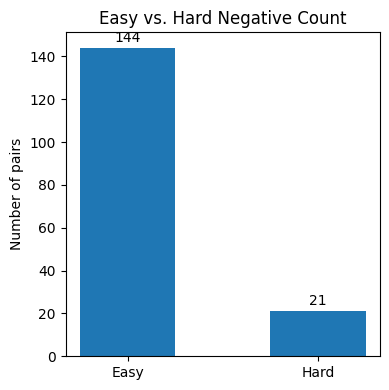

In [15]:
# Easy / Hard 비율 시각화 (막대그래프)
#
# 준비:
#   1) 메모리 변수 decoys  → [(antibody, antigen, label, neg_type), …]
#      ─ OR ─
#   2) TSV 파일 “decoy_pairs.tsv” (antibody, antigen, label, neg_type)

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# ------------------ ① 데이터 로드 ------------------
if 'decoys' in globals():
    rows = decoys                                     # 세션 변수 사용
else:
    df = pd.read_csv("decoy_pairs.tsv", sep="\t")     # 파일 로드
    rows = df[['antibody', 'antigen', 'label', 'neg_type']].itertuples(index=False, name=None)

# ------------------ ② Easy / Hard 집계 -------------
cnt = Counter(r[3] for r in rows)                    # r[3] = "easy"/"hard"
easy_n = cnt.get("easy", 0)
hard_n = cnt.get("hard", 0)

# ------------------ ③ 시각화 -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(["Easy", "Hard"], [easy_n, hard_n], width=0.5)
ax.set_title("Easy vs. Hard Negative Count")
ax.set_ylabel("Number of pairs")
for i, v in enumerate([easy_n, hard_n]):
    ax.text(i, v + max(easy_n, hard_n) * 0.02, str(v), ha='center')
plt.tight_layout()
plt.show()

In [17]:
import subprocess, json, os, pandas as pd

TMALIGN = "USalign"  # TM-align 실행 파일 경로
PDB_DIR = "/home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen"                    # 항원 PDB/AF 모델 저장 폴더
CUTOFF = 0.6                        # 또는 0.5 로 낮춰도 됨

def tm_score(p1, p2):
    """
    USalign -outfmt 2 결과에서 TM-score를 추출.
    오류 발생 시 None 반환하여 건너뜀.
    """
    try:
        # 파일 존재 체크
        for p in (p1, p2):
            if not os.path.exists(p):
                return None

        # USalign 실행
        cmd = [TMALIGN, p1, p2, "-outfmt", "2"]
        out_lines = subprocess.check_output(cmd, text=True).strip().splitlines()

        # TSV 파싱: 헤더('#') 라인 건너뛰고 첫 데이터 라인 사용
        for line in out_lines:
            if line.startswith("#"):
                continue
            cols = line.split("\t")
            tm1, tm2 = float(cols[2]), float(cols[3])
            return max(tm1, tm2)

        # 데이터 라인이 하나도 없으면 None
        return None

    except (subprocess.CalledProcessError, FileNotFoundError, ValueError):
        # USalign 실패, 파일 없거나 파싱 오류 시 None
        return None

# ① Hard 목록만 추출
hard_pairs = [row for row in decoys if row[3] == "hard"]

# ② native 항원 매핑 로드
ab_native = json.load(open("ab_native_map.json"))

# ③ 필터링 loop
filtered = []
dropped  = []
for ab, ag_hard, _, _ in hard_pairs:
    ag_native  = ab_native[ab]
    pdb_native = os.path.join(PDB_DIR, f"{ag_native}_A.pdb")
    pdb_hard   = os.path.join(PDB_DIR, f"{ag_hard}_A.pdb")
    tm = tm_score(pdb_native, pdb_hard)

    # tm_score()가 None을 반환했으면 건너뛰기
    if tm is None:
        print(f"[Warning] TM-score 계산 실패, 건너뜀: {ag_native} vs {ag_hard}")
        continue

    if tm > CUTOFF:
        filtered.append((ab, ag_hard, 0, "hard", tm))
    else:
        dropped.append((ab, ag_hard, tm))

print(f"Hard kept {len(filtered)} / dropped {len(dropped)} (TM ≤ {CUTOFF})")

# ④ Easy + 필터링된 Hard 합쳐 새 decoy 리스트
decoys_hardfiltered = [
    row for row in decoys if row[3] == "easy"
] + [row[:4] for row in filtered]

# (선택) TSV 저장
pd.DataFrame(decoys_hardfiltered,
             columns=["antibody","antigen","label","neg_type"]
            ).to_csv("decoys_hardFiltered.tsv", sep="\t", index=False)

Hard kept 21 / dropped 0 (TM ≤ 0.6)


In [18]:
df=pd.read_csv('decoys_hardFiltered.tsv', sep = '\t')
df

,antibody,antigen,label,neg_type
0,6x97,7sgm,0,easy
1,6x97,7zr7,0,easy
2,6x97,7o9w,0,easy
3,6x97,7su0,0,easy
4,7ew5,7wrv,0,easy
...,...,...,...,...
160,7x7o,7zf9,0,hard
161,7yqx,7soc,0,hard
162,7yqz,7wo5,0,hard
163,7zf9,7r40,0,hard


In [19]:
df_sorted = df.sort_values(by='antibody')
df_sorted.to_csv('sorted_decoy_set.csv', index=False)


#### Antigen chain만 따로 PDB로 저장.

In [10]:
#!/usr/bin/env python3
import re
from pathlib import Path

# 1) 경로 설정
INPUT_DIR = Path("/home/cseomoon/project/ABAG/2025_H_L_A/original_pdb")
OUTPUT_DIR = Path("/home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen")
OUTPUT_DIR.mkdir(exist_ok=True)

# 2) 파일명에서 PDB ID 추출용 정규식
#    예: renum_fv_7sww_0.pdb → PDB ID = 7sww
PDBID_RE = re.compile("(?P<pdb>\w+)_ABAG.pdb$", re.IGNORECASE)

# 3) 각 PDB 파일 순회
for pdb_path in INPUT_DIR.glob("*.pdb"):
    m = PDBID_RE.match(pdb_path.name)
    if not m:
        print(f"Warning: 파일명이 패턴과 맞지 않음, 건너뜀: {pdb_path.name}")
        continue

    pdb_id = m.group("pdb")
    out_path = OUTPUT_DIR / f"{pdb_id}_A.pdb"

    # 4) Chain A만 필터링해서 쓰기
    with pdb_path.open("r") as fin, out_path.open("w") as fout:
        for line in fin:
            # ATOM 또는 HETATM 레코드 중 체인 ID가 21번째 문자일 때
            if (line.startswith("ATOM") or line.startswith("HETATM")) and line[21] == "A":
                fout.write(line)

    print(f"Saved chain A to {out_path}")

Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7r40_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7vng_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7s0e_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7tfo_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7nx3_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7yqx_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7t25_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7ew5_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7shy_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/only_antigen/7sjn_A.pdb
Saved chain A to /home/cseomoon/project/ABAG/2025_H_L_A/original_pdb/o

In [11]:
import os
from Bio.PDB import PDBParser

# 1. PDB 파일들이 들어있는 디렉터리 경로
pdb_dir = "/home/cseomoon/project/ABAG/2025_H_L_A/original_pdb"

# 2. PDB 파서 생성 (QUIET=True로 로그 억제)
parser = PDBParser(QUIET=True)

# 디렉터리 내의 모든 파일 순회
for fname in os.listdir(pdb_dir):
    if not fname.lower().endswith(".pdb"):
        continue

    path = os.path.join(pdb_dir, fname)
    try:
        # 구조 읽기
        structure = parser.get_structure(fname, path)
        # 모든 체인 ID 추출
        chain_ids = {chain.id for chain in structure.get_chains()}
        # chain A 존재 여부 확인
        has_chain_A = "A" in chain_ids
        status = "체인 A 있음" if has_chain_A else "체인 A 없음"
    except Exception as e:
        status = f"읽기 오류: {e}"

    print(f"{fname}: {status}")

7r40_ABAG.pdb: 체인 A 있음
7vng_ABAG.pdb: 체인 A 있음
7s0e_ABAG.pdb: 체인 A 있음
7tfo_ABAG.pdb: 체인 A 있음
7nx3_ABAG.pdb: 체인 A 있음
7yqx_ABAG.pdb: 체인 A 있음
7t25_ABAG.pdb: 체인 A 있음
7ew5_ABAG.pdb: 체인 A 있음
7shy_ABAG.pdb: 체인 A 있음
7sjn_ABAG.pdb: 체인 A 있음
7sjo_ABAG.pdb: 체인 A 있음
7su1_ABAG.pdb: 체인 A 있음
7su0_ABAG.pdb: 체인 A 있음
7zf9_ABAG.pdb: 체인 A 있음
7np1_ABAG.pdb: 체인 A 있음
7sbg_ABAG.pdb: 체인 A 있음
7ued_ABAG.pdb: 체인 A 있음
7wo5_ABAG.pdb: 체인 A 있음
7sgm_ABAG.pdb: 체인 A 있음
7z2m_ABAG.pdb: 체인 A 있음
7vyr_ABAG.pdb: 체인 A 있음
6x97_ABAG.pdb: 체인 A 있음
7kf0_ABAG.pdb: 체인 A 있음
7kf1_ABAG.pdb: 체인 A 있음
7soc_ABAG.pdb: 체인 A 있음
7yqz_ABAG.pdb: 체인 A 있음
7o9w_ABAG.pdb: 체인 A 있음
7x7o_ABAG.pdb: 체인 A 있음
7swn_ABAG.pdb: 체인 A 있음
7tee_ABAG.pdb: 체인 A 있음
7z4t_ABAG.pdb: 체인 A 있음
7zr7_ABAG.pdb: 체인 A 있음
7wrv_ABAG.pdb: 체인 A 있음
